In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import missingno

from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

import dill
from joblib import dump # Save the best model
%cd C:\Users\user\Desktop\KUL - Mstat\Modern Data Analytics\proj\

C:\Users\user\Desktop\KUL - Mstat\Modern Data Analytics\proj


**<font color='red'>An experimental model for feature selection: What if we ignore all meteorological features?</font>**

In [2]:
# import data
mortality = pd.read_csv('mortality_merged.csv')

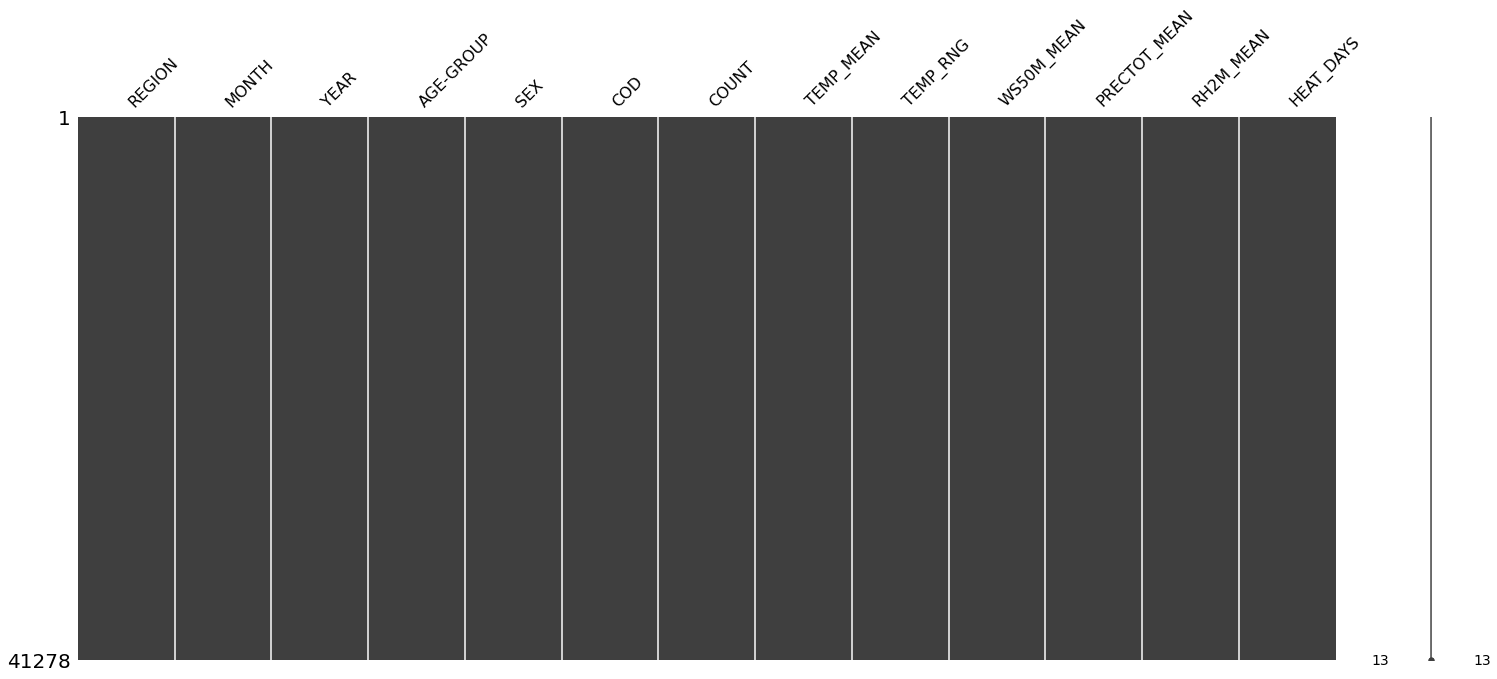

In [3]:
# Check for missing values, it seems alright
missingno.matrix(mortality)

In [4]:
class subset_helper():
    def __init__(self, data):
        self.data = data
        
    def get_summer(self, df):
        return df[(df['MONTH'] <= 8) & (df['MONTH'] >= 5)]

    def get_disease(self, df):
        diseases = ('Diseases of the circulatory system', 
                    'Diseases of the respiratory system', 
                    'Diseases of the skin and subcutaneous tissue')
        return df[df['COD'].isin(diseases)]
    
    def subset(self):
        self.data = self.get_summer(self.data)
        self.data = self.get_disease(self.data)
        return self.data
mortality = subset_helper(mortality).subset()

In [5]:
# Train-test split
TEST_SIZE = 0.2
SEED = 467051528
X_train, X_test, y_train, y_test = train_test_split(mortality.drop('COUNT', axis = 1), 
                                                    mortality['COUNT'], 
                                                    test_size = TEST_SIZE,
                                                    random_state = SEED,
                                                    shuffle = True)

In [6]:
# Preprocessing steps
categorical_transformer = OneHotEncoder(drop = 'first')

categorical_features = ['REGION', 'AGE-GROUP', 'SEX', 'COD']

preprocessor = ColumnTransformer(
    transformers = [
        ('drop_columns', 'drop', ['YEAR', 'MONTH'] + X_train.columns.tolist()[6:]),
        ('cat', categorical_transformer, categorical_features)
    ])

In [7]:
# Parameter grids
learning_rate = np.arange(0.01, 0.2, 0.02)
max_iter = np.arange(100, 1000, 100)
max_leaf_nodes = np.arange(10, 50, 5)
max_depth = np.arange(2, 10, 1)
l2_regularization = np.arange(0, 4, 0.05)

params = {'regressor__loss': ['least_squares', 'least_absolute_deviation', 'poisson'], 
         'regressor__learning_rate': learning_rate, 
         'regressor__max_iter': max_iter,
         'regressor__max_leaf_nodes': max_leaf_nodes,
         'regressor__max_depth': max_depth,
         'regressor__l2_regularization': l2_regularization}

In [8]:
# Model
model = Pipeline(steps = [
    ('preprocessing', preprocessor),
    ('dense_transform', FunctionTransformer(lambda x: x.todense(), accept_sparse = True)),
    ('regressor', HistGradientBoostingRegressor(categorical_features = np.arange(0, 10)))
])

In [9]:
# Grid search
search = RandomizedSearchCV(model, 
                            param_distributions = params, 
                            random_state = SEED)
search.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(transformers=[('drop_columns',
                                                                               'drop',
                                                                               ['YEAR',
                                                                                'MONTH',
                                                                                'TEMP_MEAN',
                                                                                'TEMP_RNG',
                                                                                'WS50M_MEAN',
                                                                                'PRECTOT_MEAN',
                                                                                'RH2M_MEAN',
                                                                                'HEAT_DAYS']),
               

In [10]:
# Summary of grid search
pd.DataFrame(search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__max_leaf_nodes,param_regressor__max_iter,param_regressor__max_depth,param_regressor__loss,param_regressor__learning_rate,param_regressor__l2_regularization,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.484357,0.018476,0.004831,0.004321,25,100,5,least_absolute_deviation,0.17,1.8,"{'regressor__max_leaf_nodes': 25, 'regressor__...",0.890668,0.960056,0.937028,0.947465,0.918161,0.930675,0.024260,8
1,1.705212,0.028683,0.011648,0.003206,20,400,8,poisson,0.05,0.65,"{'regressor__max_leaf_nodes': 20, 'regressor__...",0.979697,0.976084,0.979787,0.977897,0.982485,0.979190,0.002135,1
2,0.267561,0.004435,0.006028,0.004921,20,200,3,poisson,0.07,2.2,"{'regressor__max_leaf_nodes': 20, 'regressor__...",0.970203,0.973832,0.973298,0.970576,0.971118,0.971806,0.001476,6
3,0.068225,0.003482,0.006343,0.005873,40,100,2,least_squares,0.07,2.45,"{'regressor__max_leaf_nodes': 40, 'regressor__...",0.633072,0.673947,0.632650,0.629849,0.614644,0.636833,0.019749,9
4,0.993028,0.008464,0.004431,0.004664,40,100,9,least_absolute_deviation,0.09,3.35,"{'regressor__max_leaf_nodes': 40, 'regressor__...",0.977618,0.975329,0.979279,0.974969,0.981049,0.977649,0.002314,4
5,1.331401,0.029518,0.013353,0.005051,10,600,8,least_squares,0.07,3,"{'regressor__max_leaf_nodes': 10, 'regressor__...",0.979479,0.975966,0.979714,0.977968,0.982108,0.979047,0.002033,3
6,0.648847,0.002454,0.000403,0.000806,30,100,9,poisson,0.19,1.05,"{'regressor__max_leaf_nodes': 30, 'regressor__...",0.979741,0.976054,0.979767,0.977877,0.982497,0.979187,0.002151,2
7,0.877234,0.016504,0.024259,0.007186,30,900,2,least_absolute_deviation,0.17,3.55,"{'regressor__max_leaf_nodes': 30, 'regressor__...",0.573844,0.646281,0.611439,0.577259,0.571418,0.596048,0.029027,10
8,0.921536,0.025254,0.014916,0.001420,15,300,5,least_squares,0.07,2.5,"{'regressor__max_leaf_nodes': 15, 'regressor__...",0.976126,0.975663,0.978762,0.976837,0.979278,0.977333,0.001437,5
9,0.246751,0.013518,0.012501,0.006250,45,100,4,least_squares,0.13,3.65,"{'regressor__max_leaf_nodes': 45, 'regressor__...",0.945488,0.958017,0.951561,0.944587,0.947646,0.949460,0.004908,7


**<font color='red'>Well, the CV score is as high as before!</font>**

In [11]:
# Best fitted scores
print(search.best_params_)
print('Best scores: ', search.best_score_)

{'regressor__max_leaf_nodes': 20, 'regressor__max_iter': 400, 'regressor__max_depth': 8, 'regressor__loss': 'poisson', 'regressor__learning_rate': 0.049999999999999996, 'regressor__l2_regularization': 0.65}
Best scores:  0.9791898678144271


In [12]:
# Test performance
model_chosen = search.best_estimator_
y_pred = model_chosen.predict(X_test)

**<font color='blue'>Wait a moment... Training MSE increases by a lot</font>**

In [13]:
# Test loss
mean_squared_error(y_pred, y_test)

107.15925157597178

In [14]:
# Training loss
mean_squared_error(y_train, model_chosen.predict(X_train))

105.26413498388695

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


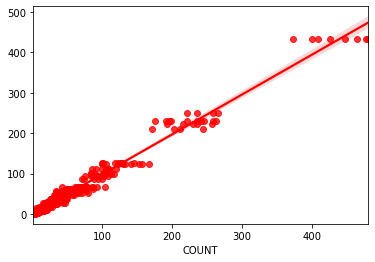

In [15]:
# Test data: y_test, y_pred
sns.regplot(y_test, y_pred, color = 'red')

In [16]:
# R-squared between y_pred and y_test
np.corrcoef(y_test, y_pred)

array([[1.        , 0.99008937],
       [0.99008937, 1.        ]])

**<font color='blue'>There are horizontal strip patterns between observed and predicted death! If you don't include the temperature and other meterological features, your model is underfitting!!</font>**

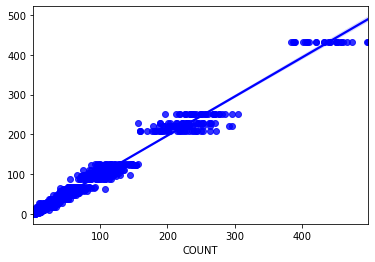

In [17]:
# Training data: y_train, y_pred_train
y_pred_train = model_chosen.predict(X_train)
sns.regplot(x = y_train, y = y_pred_train, color = 'blue')

In [18]:
# R-squared between y_pred and y_pred_train
np.corrcoef(y_train, y_pred_train)

array([[1.        , 0.99048434],
       [0.99048434, 1.        ]])